### Load libraries

In [1]:
library(xgboost)
library(data.table)
library(Metrics)
library(rBayesianOptimization)

### Load data (train & test)

In [2]:
train = fread("../input/train.csv", showProgress = TRUE)
test = fread("../input/test.csv", showProgress = TRUE)

y_train = train$loss
train[, c("id", "loss") := NULL]
test[, c("id") := NULL]

Read 188318 rows and 132 (of 132) columns from 0.065 GB file in 00:00:03


### Manage cat vars

In [3]:
ntrain = nrow(train)
df_all = rbind(train, test)

In [4]:
features = names(train)

for (f in features) {
  if (class(df_all[[f]])=="character") {
    levels <- sort(unique(df_all[[f]]))
    df_all[[f]] <- as.integer(factor(df_all[[f]], levels=levels))
  }
}

### Prepare dataset

In [5]:
df_train = df_all[1:ntrain,]
df_test = df_all[(ntrain+1):nrow(df_all),]

dtrain = xgb.DMatrix(as.matrix(df_train), label=y_train)
dtest = xgb.DMatrix(as.matrix(df_test))

### save or load data matrix

In [6]:
system.time( xgb.DMatrix(as.matrix(df_train), label=y_train) )

xgb.DMatrix.save(dtrain, '../input/dtrain.dat')
system.time( xgb.DMatrix('../input/dtrain.dat') )

   user  system elapsed 
  0.511   0.265   0.785 

[1] TRUE

[16:41:35] 188318x130 matrix with 24481340 entries loaded from ../input/dtrain.dat


   user  system elapsed 
  0.000   0.132   0.133 

### train model

In [12]:
set.seed(2017)

xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.3,
  objective = 'reg:linear',
  max_depth = 6
)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=10, 
    maximize = F)

## save and load model

In [13]:
xgb.save(model, '../models/xgb.dat')
model1 = xgb.load('../models/xgb.dat')

[1] TRUE

## Tuning

### Toy example 
[BayesianOptimization](https://cran.r-project.org/web/packages/rBayesianOptimization/rBayesianOptimization.pdf)

In [9]:
test.fun <- function(x) {
    list(Score = exp(-(x - 2)^2) + exp(-(x - 6)^2/10) + 1/ (x^2 + 1), Pred = 0)
}

## Set larger init_points and n_iter for better optimization result
OPT_Res <- BayesianOptimization(test.fun,
    bounds = list(x = c(1, 3)),
    init_points = 3, 
    n_iter = 10,
    acq = "ucb", 
    verbose = TRUE)

elapsed = 0.00	Round = 1	x = 2.5340	Value = 1.1874 
elapsed = 0.01	Round = 2	x = 2.6792	Value = 1.0847 
elapsed = 0.00	Round = 3	x = 2.1492	Value = 1.3829 
elapsed = 0.00	Round = 4	x = 1.0000	Value = 0.9500 
elapsed = 0.00	Round = 5	x = 1.7262	Value = 1.3400 
elapsed = 0.00	Round = 6	x = 1.9937	Value = 1.4019 
elapsed = 0.00	Round = 7	x = 2.0009	Value = 1.4019 
elapsed = 0.00	Round = 8	x = 2.0009	Value = 1.4019 
elapsed = 0.00	Round = 9	x = 2.0009	Value = 1.4019 
elapsed = 0.00	Round = 10	x = 2.0009	Value = 1.4019 
elapsed = 0.00	Round = 11	x = 2.0003	Value = 1.4019 
elapsed = 0.00	Round = 12	x = 1.9985	Value = 1.4019 
elapsed = 0.00	Round = 13	x = 2.0003	Value = 1.4019 

 Best Parameters Found: 
Round = 7	x = 2.0009	Value = 1.4019 


Loading required package: ggplot2


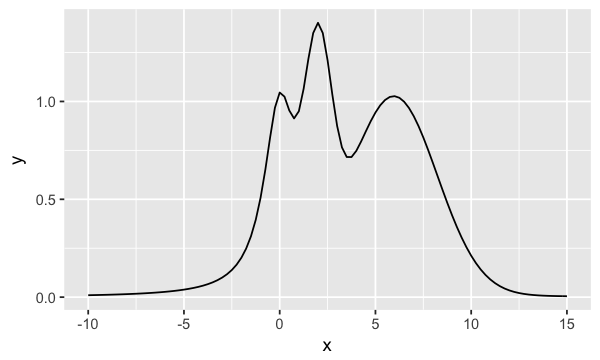

In [10]:
require(ggplot2)


my_fun <- function(x) { exp(-(x - 2)^2) + exp(-(x - 6)^2/10) + 1/ (x^2 + 1) }
options(repr.plot.width=5, repr.plot.height=3)
ggplot(data.frame(x=c(-10, 15)), aes(x)) + stat_function(fun=my_fun)

### xgboost

In [11]:
cv.folds <- KFold(y_train, nfolds = 5,stratified = FALSE, seed = 0)

xgb.cv.bayes <- function(max_depth, min_child_weight, subsample) {
    cv <- xgb.cv(
        params = list(
            booster = "gbtree", eta = 0.01,
            max_depth = max_depth,
            min_child_weight = min_child_weight,
            subsample = subsample, colsample_bytree = 0.3,
            lambda = 1, alpha = 0,
            objective = 'reg:linear',
            eval_metric = "mae"),
        data = dtrain, nround = 10,
        folds = cv.folds, prediction = TRUE, showsd = TRUE,
        early_stop_round = 5, maximize = FALSE, verbose = 1)

        list(Score = mean(cv$evaluation_log$test_mae_mean), Pred = cv$pred)
}

opt.res <- BayesianOptimization(xgb.cv.bayes,
    bounds = list(max_depth = c(2L, 6L),
                  min_child_weight = c(1L, 10L),
                  subsample = c(0.5, 0.8)),
    init_points = 10, n_iter = 3,
    acq = "ucb", kappa = 2.576, eps = 0.0,
    verbose = TRUE)

elapsed = 23.34	Round = 1	max_depth = 4.0000	min_child_weight = 3.0000	subsample = 0.7627	Value = 2874.9637 
elapsed = 23.07	Round = 2	max_depth = 4.0000	min_child_weight = 4.0000	subsample = 0.7474	Value = 2875.0014 
elapsed = 30.42	Round = 3	max_depth = 6.0000	min_child_weight = 1.0000	subsample = 0.7126	Value = 2875.1454 
elapsed = 23.72	Round = 4	max_depth = 4.0000	min_child_weight = 6.0000	subsample = 0.5198	Value = 2874.9574 
elapsed = 29.25	Round = 5	max_depth = 6.0000	min_child_weight = 8.0000	subsample = 0.7359	Value = 2875.0316 
elapsed = 23.25	Round = 6	max_depth = 4.0000	min_child_weight = 6.0000	subsample = 0.5114	Value = 2874.9712 
elapsed = 20.10	Round = 7	max_depth = 3.0000	min_child_weight = 9.0000	subsample = 0.5217	Value = 2874.9044 
elapsed = 19.24	Round = 8	max_depth = 3.0000	min_child_weight = 3.0000	subsample = 0.7744	Value = 2874.9235 
elapsed = 19.59	Round = 9	max_depth = 3.0000	min_child_weight = 6.0000	subsample = 0.7347	Value = 2874.9176 
elapsed = 25.86	Rou

## Advanced features
1. Customization of objective & eval metrics
2. "Continous" training
3. Embeded feature importance estimator
4. Early-stopping

### Customization eval metrics

In [12]:
xg_eval_mae <- function (y_pred, dtrain) {
   y = getinfo(dtrain, "label")
   err= mae(y, y_pred)
   return (list(metric = "error", value = err))
}


### Customization of objective
more [details](https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function)

In [13]:
logcoshobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  grad <- tanh(preds-labels)
  hess <- 1-grad*grad
  return(list(grad = grad, hess = hess))
}

cauchyobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  c <- 3  #the lower the "slower/smoother" the loss is. Cross-Validate.
  x <-  preds-labels
  grad <- x / (x^2/c^2+1)
  hess <- -c^2*(x^2-c^2)/(x^2+c^2)^2
  return(list(grad = grad, hess = hess))
}


fairobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  c <- 2 #the lower the "slower/smoother" the loss is. Cross-Validate.
  x <-  preds-labels
  grad <- c*x / (abs(x)+c)
  hess <- c^2 / (abs(x)+c)^2
  return(list(grad = grad, hess = hess))
}

In [22]:
xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.3,
  objective = logcoshobj,    # <<<<=== custom objective
  eval_metric = xg_eval_mae, # <<<<=== custom eval mae
  max_depth = 6
)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=10, 
    maximize = F)

## "Continous" training

In [19]:
model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=2, 
    maximize = F)

ptrain = predict(model, dtrain, outputmargin=TRUE)
setinfo(dtrain, "base_margin", ptrain)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=10, 
    maximize = F)


[1] TRUE

## feature importance estimator

In [20]:
importance <- xgb.importance(feature_names = names(df_train), model = model)
head(importance, 20)

Feature,Gain,Cover,Frequency
cat79,0.08887786,0.02427799,0.041528239
cat87,0.07848086,0.04256799,0.028239203
cat86,0.05791191,0.05861953,0.069767442
cat71,0.04594016,0.04935934,0.036544850
cat57,0.04246698,0.03706364,0.013289037
cat80,0.04049229,0.02643343,0.029900332
cat82,0.03665452,0.03640738,0.023255814
cat75,0.03582058,0.04588999,0.031561462
cat13,0.03458378,0.04764305,0.011627907
cat26,0.02979773,0.01888573,0.014950166


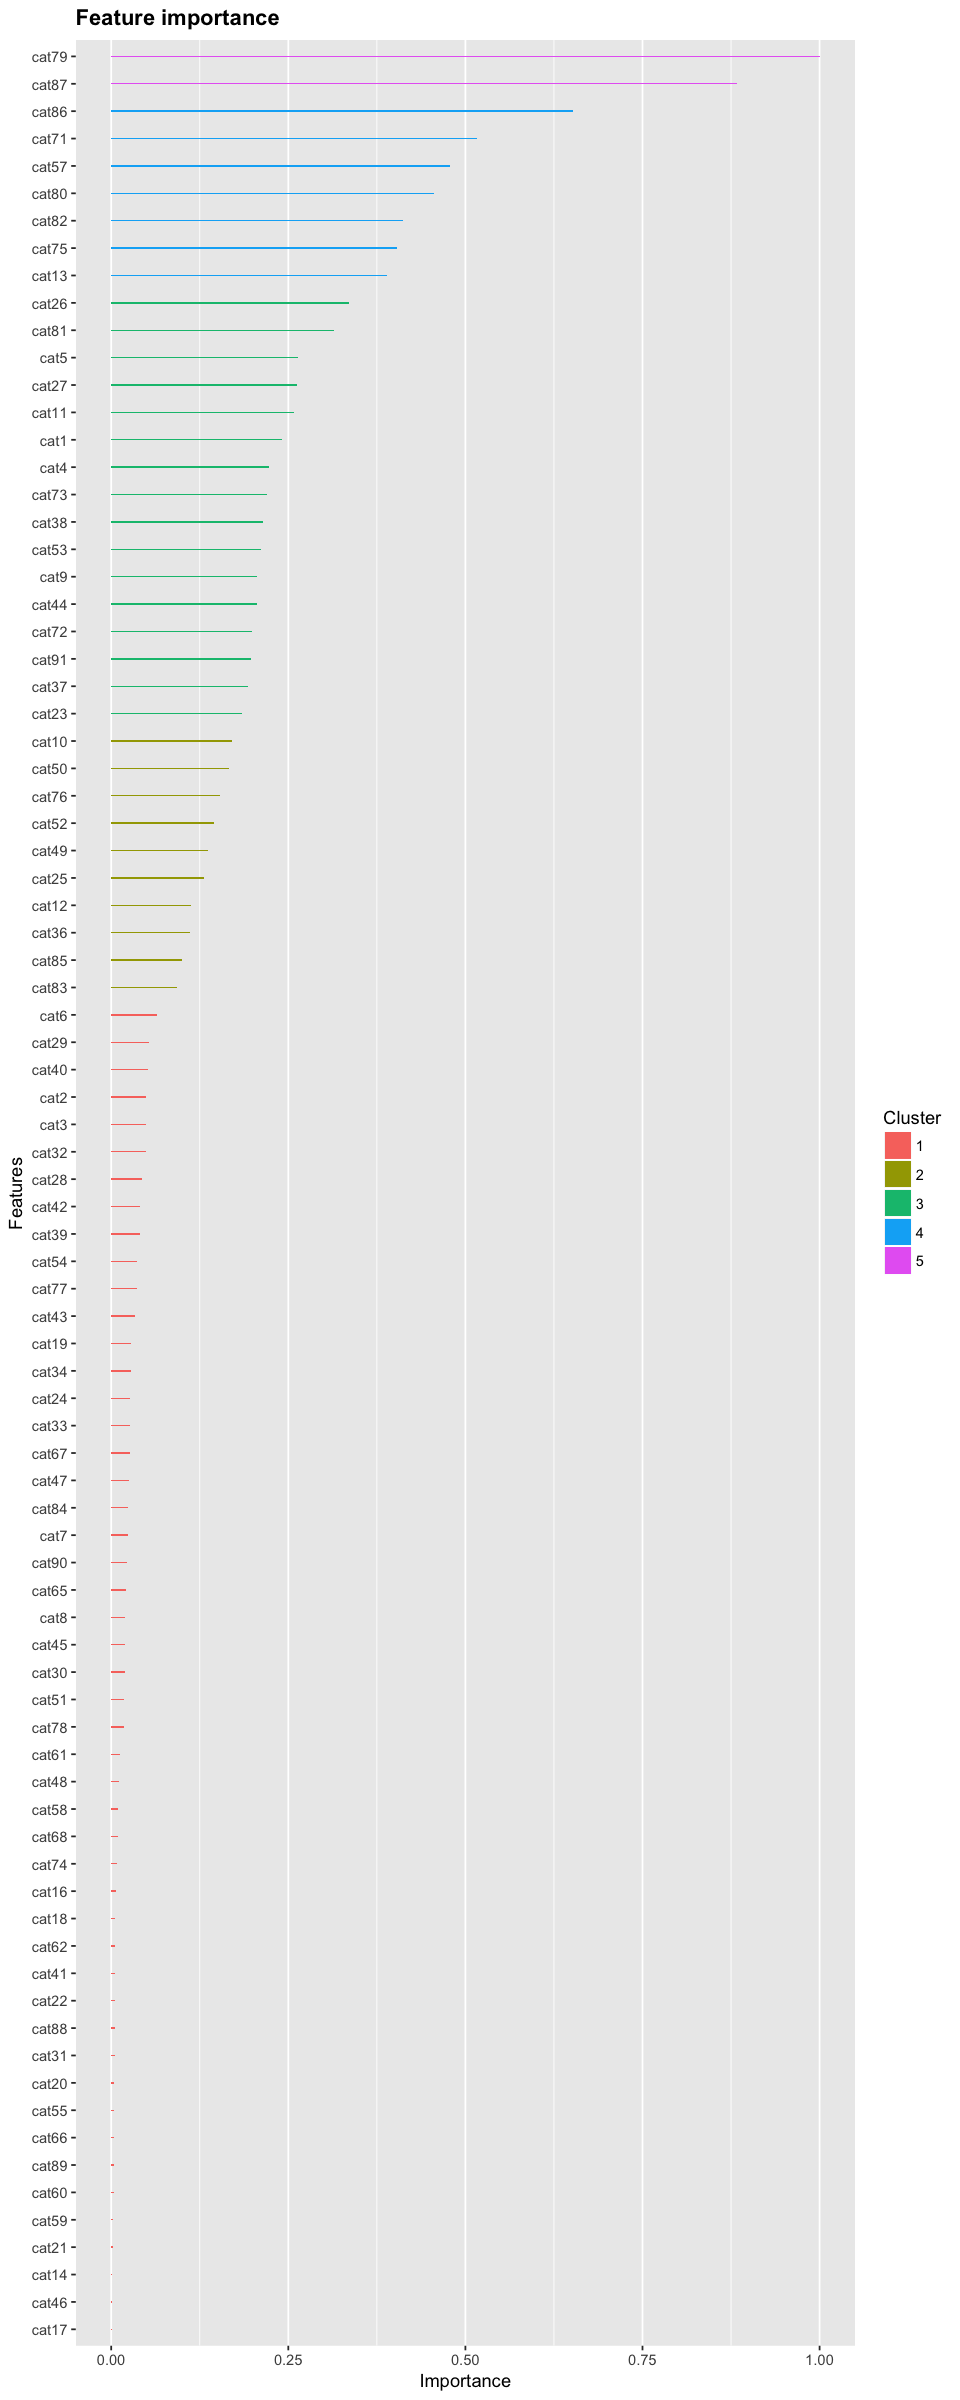

In [21]:
#install.packages("ggplot2")
#install.packages("Ckmeans.1d.dp")
#install.packages("vcd")

library(ggplot2)

importance_matrix <- xgb.importance(names(train), model = model)

#xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")

options(repr.plot.width=8, repr.plot.height=20)
(gg <- xgb.ggplot.importance(importance_matrix, measure = "Gain", rel_to_first = TRUE)) #Frequince, Cover


## Questoins:
1. what does mean feature importance?
2. what the difference between in FI between: Gain, Cover, Frequences?

## Links
* [xbfi](https://github.com/Far0n/xgbfi) worth to check